# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        # w=w[0]
        w=torch.randn(w[0].shape).cuda()*0.1
        a=torch.randn(1).cuda()*0.1
        if a>0.39:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.39:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.311231, Accuracy: 8.59
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.339116, Accuracy: 10.94
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.327098, Accuracy: 9.38
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.270108, Accuracy: 15.62
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.262264, Accuracy: 14.06
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.206338, Accuracy: 14.45
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.226894, Accuracy: 16.02
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.278051, Accuracy: 14.45
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.244595, Accuracy: 17.97
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.200336, Accuracy: 20.31
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.186970, Accuracy: 16.02
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.228024, Accuracy: 16.41
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.160575, Accuracy: 21.88
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.155728, Accuracy: 16.41
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.210832, Accuracy: 16.02
Train Epoch:

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.413005, Accuracy: 45.31
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.460962, Accuracy: 44.53
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.402172, Accuracy: 46.09
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.355134, Accuracy: 48.44
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.463838, Accuracy: 43.36
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.245975, Accuracy: 53.12
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.439203, Accuracy: 49.61
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.443569, Accuracy: 47.66
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.388707, Accuracy: 49.61
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.287963, Accuracy: 49.61
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.331818, Accuracy: 51.17
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.548450, Accuracy: 43.75
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.406112, Accuracy: 51.17
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.348970, Accuracy: 53.12
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.459210, Accuracy: 4

Train Epoch: 5 [24320/50000 (54%)]	Loss: 0.982057, Accuracy: 67.19
Train Epoch: 5 [25600/50000 (57%)]	Loss: 1.123857, Accuracy: 57.03
Train Epoch: 5 [26880/50000 (60%)]	Loss: 1.148962, Accuracy: 60.16
Train Epoch: 5 [28160/50000 (62%)]	Loss: 1.029605, Accuracy: 64.45
Train Epoch: 5 [29440/50000 (65%)]	Loss: 1.027042, Accuracy: 63.67
Train Epoch: 5 [30720/50000 (68%)]	Loss: 1.078112, Accuracy: 62.11
Train Epoch: 5 [32000/50000 (71%)]	Loss: 1.031485, Accuracy: 66.02
Train Epoch: 5 [33280/50000 (74%)]	Loss: 0.994381, Accuracy: 63.28
Train Epoch: 5 [34560/50000 (77%)]	Loss: 1.067903, Accuracy: 62.89
Train Epoch: 5 [35840/50000 (80%)]	Loss: 0.899276, Accuracy: 70.31
Train Epoch: 5 [37120/50000 (82%)]	Loss: 0.988397, Accuracy: 62.50
Train Epoch: 5 [38400/50000 (85%)]	Loss: 0.813287, Accuracy: 69.14
Train Epoch: 5 [39680/50000 (88%)]	Loss: 1.009823, Accuracy: 66.02
Train Epoch: 5 [40960/50000 (91%)]	Loss: 0.953423, Accuracy: 66.41
Train Epoch: 5 [42240/50000 (94%)]	Loss: 0.852480, Accuracy: 7

Train Epoch: 8 [37120/50000 (82%)]	Loss: 0.734622, Accuracy: 77.34
Train Epoch: 8 [38400/50000 (85%)]	Loss: 0.637771, Accuracy: 76.17
Train Epoch: 8 [39680/50000 (88%)]	Loss: 0.773947, Accuracy: 70.70
Train Epoch: 8 [40960/50000 (91%)]	Loss: 0.718467, Accuracy: 77.73
Train Epoch: 8 [42240/50000 (94%)]	Loss: 0.714806, Accuracy: 77.73
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.711279, Accuracy: 74.22
Train Epoch: 8 [35000/50000 (99%)]	Loss: 0.720297, Accuracy: 74.00

Validation set: Average loss: 0.9409, Accuracy: 3340/5000 (66.00%)

the time of this epoch:[35.43855571746826 s]
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.715351, Accuracy: 76.56
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.700502, Accuracy: 76.95
Train Epoch: 9 [2560/50000 (6%)]	Loss: 0.836356, Accuracy: 73.05
Train Epoch: 9 [3840/50000 (9%)]	Loss: 0.812674, Accuracy: 71.48
Train Epoch: 9 [5120/50000 (11%)]	Loss: 0.697435, Accuracy: 78.12
Train Epoch: 9 [6400/50000 (14%)]	Loss: 0.823956, Accuracy: 70.31
Train Epoch: 9 [7680/50000 (

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.514987, Accuracy: 83.59
Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.595921, Accuracy: 81.25
Train Epoch: 12 [2560/50000 (6%)]	Loss: 0.622380, Accuracy: 79.30
Train Epoch: 12 [3840/50000 (9%)]	Loss: 0.545080, Accuracy: 78.12
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.583440, Accuracy: 79.69
Train Epoch: 12 [6400/50000 (14%)]	Loss: 0.671750, Accuracy: 78.91
Train Epoch: 12 [7680/50000 (17%)]	Loss: 0.609548, Accuracy: 76.95
Train Epoch: 12 [8960/50000 (20%)]	Loss: 0.650516, Accuracy: 76.56
Train Epoch: 12 [10240/50000 (23%)]	Loss: 0.556580, Accuracy: 82.81
Train Epoch: 12 [11520/50000 (26%)]	Loss: 0.583711, Accuracy: 81.25
Train Epoch: 12 [12800/50000 (28%)]	Loss: 0.508519, Accuracy: 82.03
Train Epoch: 12 [14080/50000 (31%)]	Loss: 0.594467, Accuracy: 82.42
Train Epoch: 12 [15360/50000 (34%)]	Loss: 0.560569, Accuracy: 80.86
Train Epoch: 12 [16640/50000 (37%)]	Loss: 0.612970, Accuracy: 80.86
Train Epoch: 12 [17920/50000 (40%)]	Loss: 0.656152, Accuracy: 7

Train Epoch: 15 [8960/50000 (20%)]	Loss: 0.515262, Accuracy: 82.42
Train Epoch: 15 [10240/50000 (23%)]	Loss: 0.494216, Accuracy: 83.59
Train Epoch: 15 [11520/50000 (26%)]	Loss: 0.527224, Accuracy: 84.77
Train Epoch: 15 [12800/50000 (28%)]	Loss: 0.536478, Accuracy: 82.42
Train Epoch: 15 [14080/50000 (31%)]	Loss: 0.584417, Accuracy: 82.03
Train Epoch: 15 [15360/50000 (34%)]	Loss: 0.534461, Accuracy: 78.12
Train Epoch: 15 [16640/50000 (37%)]	Loss: 0.509017, Accuracy: 83.59
Train Epoch: 15 [17920/50000 (40%)]	Loss: 0.571840, Accuracy: 78.12
Train Epoch: 15 [19200/50000 (43%)]	Loss: 0.606252, Accuracy: 78.12
Train Epoch: 15 [20480/50000 (45%)]	Loss: 0.507946, Accuracy: 82.42
Train Epoch: 15 [21760/50000 (48%)]	Loss: 0.530889, Accuracy: 83.98
Train Epoch: 15 [23040/50000 (51%)]	Loss: 0.509428, Accuracy: 83.59
Train Epoch: 15 [24320/50000 (54%)]	Loss: 0.616843, Accuracy: 76.17
Train Epoch: 15 [25600/50000 (57%)]	Loss: 0.520993, Accuracy: 82.42
Train Epoch: 15 [26880/50000 (60%)]	Loss: 0.47380

Train Epoch: 18 [19200/50000 (43%)]	Loss: 0.523053, Accuracy: 82.81
Train Epoch: 18 [20480/50000 (45%)]	Loss: 0.523208, Accuracy: 78.52
Train Epoch: 18 [21760/50000 (48%)]	Loss: 0.603078, Accuracy: 80.86
Train Epoch: 18 [23040/50000 (51%)]	Loss: 0.414518, Accuracy: 88.67
Train Epoch: 18 [24320/50000 (54%)]	Loss: 0.478309, Accuracy: 84.38
Train Epoch: 18 [25600/50000 (57%)]	Loss: 0.511876, Accuracy: 83.98
Train Epoch: 18 [26880/50000 (60%)]	Loss: 0.542047, Accuracy: 80.47
Train Epoch: 18 [28160/50000 (62%)]	Loss: 0.478699, Accuracy: 84.77
Train Epoch: 18 [29440/50000 (65%)]	Loss: 0.491384, Accuracy: 82.03
Train Epoch: 18 [30720/50000 (68%)]	Loss: 0.532244, Accuracy: 82.42
Train Epoch: 18 [32000/50000 (71%)]	Loss: 0.433749, Accuracy: 84.77
Train Epoch: 18 [33280/50000 (74%)]	Loss: 0.499567, Accuracy: 82.42
Train Epoch: 18 [34560/50000 (77%)]	Loss: 0.437732, Accuracy: 83.98
Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.416609, Accuracy: 87.50
Train Epoch: 18 [37120/50000 (82%)]	Loss: 0.5632

Train Epoch: 21 [28160/50000 (62%)]	Loss: 0.388621, Accuracy: 87.89
Train Epoch: 21 [29440/50000 (65%)]	Loss: 0.502320, Accuracy: 82.81
Train Epoch: 21 [30720/50000 (68%)]	Loss: 0.513751, Accuracy: 83.98
Train Epoch: 21 [32000/50000 (71%)]	Loss: 0.516789, Accuracy: 82.03
Train Epoch: 21 [33280/50000 (74%)]	Loss: 0.482783, Accuracy: 82.81
Train Epoch: 21 [34560/50000 (77%)]	Loss: 0.529862, Accuracy: 80.86
Train Epoch: 21 [35840/50000 (80%)]	Loss: 0.578160, Accuracy: 80.08
Train Epoch: 21 [37120/50000 (82%)]	Loss: 0.525309, Accuracy: 82.03
Train Epoch: 21 [38400/50000 (85%)]	Loss: 0.476981, Accuracy: 80.47
Train Epoch: 21 [39680/50000 (88%)]	Loss: 0.468976, Accuracy: 85.55
Train Epoch: 21 [40960/50000 (91%)]	Loss: 0.422967, Accuracy: 86.33
Train Epoch: 21 [42240/50000 (94%)]	Loss: 0.443038, Accuracy: 86.33
Train Epoch: 21 [43520/50000 (97%)]	Loss: 0.500011, Accuracy: 79.69
Train Epoch: 21 [35000/50000 (99%)]	Loss: 0.528712, Accuracy: 84.50

Validation set: Average loss: 1.1093, Accuracy:

Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.489886, Accuracy: 80.86
Train Epoch: 24 [39680/50000 (88%)]	Loss: 0.347471, Accuracy: 87.89
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.481066, Accuracy: 82.42
Train Epoch: 24 [42240/50000 (94%)]	Loss: 0.461330, Accuracy: 85.16
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.468606, Accuracy: 84.77
Train Epoch: 24 [35000/50000 (99%)]	Loss: 0.531020, Accuracy: 82.50

Validation set: Average loss: 0.7656, Accuracy: 3839/5000 (76.00%)

the time of this epoch:[35.41814827919006 s]

Test set: Average loss: 0.7853, Accuracy: 7616/10000 (76.16%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.447501, Accuracy: 85.94
Train Epoch: 25 [1280/50000 (3%)]	Loss: 0.516408, Accuracy: 85.94
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.413530, Accuracy: 87.11
Train Epoch: 25 [3840/50000 (9%)]	Loss: 0.404554, Accuracy: 85.94
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.449954, Accuracy: 85.16
Train Epoch: 25 [6400/50000 (14%)]	Loss: 0.391344, Accuracy: 86.72
Train Epoch: 25 [76

Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.312263, Accuracy: 89.84
Train Epoch: 28 [2560/50000 (6%)]	Loss: 0.397655, Accuracy: 84.38
Train Epoch: 28 [3840/50000 (9%)]	Loss: 0.505681, Accuracy: 83.20
Train Epoch: 28 [5120/50000 (11%)]	Loss: 0.342300, Accuracy: 87.50
Train Epoch: 28 [6400/50000 (14%)]	Loss: 0.366402, Accuracy: 88.28
Train Epoch: 28 [7680/50000 (17%)]	Loss: 0.471862, Accuracy: 81.25
Train Epoch: 28 [8960/50000 (20%)]	Loss: 0.463778, Accuracy: 84.38
Train Epoch: 28 [10240/50000 (23%)]	Loss: 0.433545, Accuracy: 85.55
Train Epoch: 28 [11520/50000 (26%)]	Loss: 0.419777, Accuracy: 84.38
Train Epoch: 28 [12800/50000 (28%)]	Loss: 0.404555, Accuracy: 85.16
Train Epoch: 28 [14080/50000 (31%)]	Loss: 0.576933, Accuracy: 81.25
Train Epoch: 28 [15360/50000 (34%)]	Loss: 0.439598, Accuracy: 82.03
Train Epoch: 28 [16640/50000 (37%)]	Loss: 0.438998, Accuracy: 85.55
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.459014, Accuracy: 83.59
Train Epoch: 28 [19200/50000 (43%)]	Loss: 0.456632, Accura

Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.380533, Accuracy: 86.72
Train Epoch: 31 [11520/50000 (26%)]	Loss: 0.509298, Accuracy: 84.38
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.385957, Accuracy: 86.33
Train Epoch: 31 [14080/50000 (31%)]	Loss: 0.395295, Accuracy: 86.72
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.456535, Accuracy: 87.11
Train Epoch: 31 [16640/50000 (37%)]	Loss: 0.370991, Accuracy: 87.89
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.493438, Accuracy: 82.81
Train Epoch: 31 [19200/50000 (43%)]	Loss: 0.477813, Accuracy: 85.94
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.452492, Accuracy: 86.33
Train Epoch: 31 [21760/50000 (48%)]	Loss: 0.441607, Accuracy: 85.55
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.359696, Accuracy: 87.50
Train Epoch: 31 [24320/50000 (54%)]	Loss: 0.454533, Accuracy: 83.20
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.430003, Accuracy: 85.16
Train Epoch: 31 [26880/50000 (60%)]	Loss: 0.423855, Accuracy: 85.94
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.5180

Train Epoch: 32 [2560/50000 (6%)]	Loss: 0.475454, Accuracy: 84.77
Train Epoch: 32 [3840/50000 (9%)]	Loss: 0.390038, Accuracy: 85.55
Train Epoch: 32 [5120/50000 (11%)]	Loss: 0.378589, Accuracy: 89.45
Train Epoch: 32 [6400/50000 (14%)]	Loss: 0.393116, Accuracy: 87.11
Train Epoch: 32 [7680/50000 (17%)]	Loss: 0.450391, Accuracy: 83.98
Train Epoch: 32 [8960/50000 (20%)]	Loss: 0.369615, Accuracy: 87.11
Train Epoch: 32 [10240/50000 (23%)]	Loss: 0.324519, Accuracy: 90.23
Train Epoch: 32 [11520/50000 (26%)]	Loss: 0.379370, Accuracy: 89.45
Train Epoch: 32 [12800/50000 (28%)]	Loss: 0.409424, Accuracy: 86.33
Train Epoch: 32 [14080/50000 (31%)]	Loss: 0.361897, Accuracy: 88.28
Train Epoch: 32 [15360/50000 (34%)]	Loss: 0.340833, Accuracy: 87.89
Train Epoch: 32 [16640/50000 (37%)]	Loss: 0.386948, Accuracy: 87.11
Train Epoch: 32 [17920/50000 (40%)]	Loss: 0.431830, Accuracy: 85.55
Train Epoch: 32 [19200/50000 (43%)]	Loss: 0.444818, Accuracy: 84.38
Train Epoch: 32 [20480/50000 (45%)]	Loss: 0.398851, Accu

Train Epoch: 35 [11520/50000 (26%)]	Loss: 0.338270, Accuracy: 89.45
Train Epoch: 35 [12800/50000 (28%)]	Loss: 0.300018, Accuracy: 88.67
Train Epoch: 35 [14080/50000 (31%)]	Loss: 0.406617, Accuracy: 86.33
Train Epoch: 35 [15360/50000 (34%)]	Loss: 0.361134, Accuracy: 88.28
Train Epoch: 35 [16640/50000 (37%)]	Loss: 0.419188, Accuracy: 84.77
Train Epoch: 35 [17920/50000 (40%)]	Loss: 0.462072, Accuracy: 83.98
Train Epoch: 35 [19200/50000 (43%)]	Loss: 0.392304, Accuracy: 88.28
Train Epoch: 35 [20480/50000 (45%)]	Loss: 0.391223, Accuracy: 87.11
Train Epoch: 35 [21760/50000 (48%)]	Loss: 0.353737, Accuracy: 89.45
Train Epoch: 35 [23040/50000 (51%)]	Loss: 0.417725, Accuracy: 85.55
Train Epoch: 35 [24320/50000 (54%)]	Loss: 0.447257, Accuracy: 82.81
Train Epoch: 35 [25600/50000 (57%)]	Loss: 0.406599, Accuracy: 84.77
Train Epoch: 35 [26880/50000 (60%)]	Loss: 0.415050, Accuracy: 84.77
Train Epoch: 35 [28160/50000 (62%)]	Loss: 0.390661, Accuracy: 86.33
Train Epoch: 35 [29440/50000 (65%)]	Loss: 0.3566

Train Epoch: 37 [3840/50000 (9%)]	Loss: 0.381415, Accuracy: 86.33
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.437072, Accuracy: 84.77
Train Epoch: 37 [6400/50000 (14%)]	Loss: 0.402677, Accuracy: 87.11
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.387824, Accuracy: 86.33
Train Epoch: 37 [8960/50000 (20%)]	Loss: 0.404656, Accuracy: 86.72
Train Epoch: 37 [10240/50000 (23%)]	Loss: 0.375614, Accuracy: 86.72
Train Epoch: 37 [11520/50000 (26%)]	Loss: 0.347795, Accuracy: 89.45
Train Epoch: 37 [12800/50000 (28%)]	Loss: 0.367702, Accuracy: 86.72
Train Epoch: 37 [14080/50000 (31%)]	Loss: 0.320867, Accuracy: 88.67
Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.316290, Accuracy: 90.23
Train Epoch: 37 [16640/50000 (37%)]	Loss: 0.333684, Accuracy: 89.45
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.360871, Accuracy: 87.50
Train Epoch: 37 [19200/50000 (43%)]	Loss: 0.447353, Accuracy: 83.59
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.385064, Accuracy: 89.06
Train Epoch: 37 [21760/50000 (48%)]	Loss: 0.416047, Ac

Train Epoch: 40 [14080/50000 (31%)]	Loss: 0.417152, Accuracy: 86.33
Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.441944, Accuracy: 85.16
Train Epoch: 40 [16640/50000 (37%)]	Loss: 0.466623, Accuracy: 82.03
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.506006, Accuracy: 82.42
Train Epoch: 40 [19200/50000 (43%)]	Loss: 0.399926, Accuracy: 85.16
Train Epoch: 40 [20480/50000 (45%)]	Loss: 0.251223, Accuracy: 92.97
Train Epoch: 40 [21760/50000 (48%)]	Loss: 0.396712, Accuracy: 86.72
Train Epoch: 40 [23040/50000 (51%)]	Loss: 0.530101, Accuracy: 81.64
Train Epoch: 40 [24320/50000 (54%)]	Loss: 0.307461, Accuracy: 89.84
Train Epoch: 40 [25600/50000 (57%)]	Loss: 0.347333, Accuracy: 87.89
Train Epoch: 40 [26880/50000 (60%)]	Loss: 0.387809, Accuracy: 86.72
Train Epoch: 40 [28160/50000 (62%)]	Loss: 0.391342, Accuracy: 86.72
Train Epoch: 40 [29440/50000 (65%)]	Loss: 0.378428, Accuracy: 86.33
Train Epoch: 40 [30720/50000 (68%)]	Loss: 0.364254, Accuracy: 87.50
Train Epoch: 40 [32000/50000 (71%)]	Loss: 0.3777

Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.410184, Accuracy: 85.16
Train Epoch: 43 [24320/50000 (54%)]	Loss: 0.295963, Accuracy: 89.84
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.457582, Accuracy: 84.38
Train Epoch: 43 [26880/50000 (60%)]	Loss: 0.430816, Accuracy: 86.72
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.314575, Accuracy: 88.67
Train Epoch: 43 [29440/50000 (65%)]	Loss: 0.480447, Accuracy: 84.38
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.461182, Accuracy: 83.98
Train Epoch: 43 [32000/50000 (71%)]	Loss: 0.380276, Accuracy: 87.50
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.361196, Accuracy: 85.94
Train Epoch: 43 [34560/50000 (77%)]	Loss: 0.370053, Accuracy: 88.28
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.359543, Accuracy: 88.28
Train Epoch: 43 [37120/50000 (82%)]	Loss: 0.325421, Accuracy: 91.02
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.375385, Accuracy: 88.67
Train Epoch: 43 [39680/50000 (88%)]	Loss: 0.355275, Accuracy: 88.67
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.4276

Train Epoch: 46 [33280/50000 (74%)]	Loss: 0.473909, Accuracy: 85.55
Train Epoch: 46 [34560/50000 (77%)]	Loss: 0.371292, Accuracy: 88.28
Train Epoch: 46 [35840/50000 (80%)]	Loss: 0.454720, Accuracy: 84.77
Train Epoch: 46 [37120/50000 (82%)]	Loss: 0.477414, Accuracy: 84.77
Train Epoch: 46 [38400/50000 (85%)]	Loss: 0.334728, Accuracy: 87.11
Train Epoch: 46 [39680/50000 (88%)]	Loss: 0.507485, Accuracy: 85.16
Train Epoch: 46 [40960/50000 (91%)]	Loss: 0.400857, Accuracy: 85.16
Train Epoch: 46 [42240/50000 (94%)]	Loss: 0.446529, Accuracy: 85.55
Train Epoch: 46 [43520/50000 (97%)]	Loss: 0.356829, Accuracy: 88.28
Train Epoch: 46 [35000/50000 (99%)]	Loss: 0.340920, Accuracy: 90.50

Validation set: Average loss: 0.6177, Accuracy: 4030/5000 (80.00%)

the time of this epoch:[35.25643038749695 s]

Test set: Average loss: 0.6513, Accuracy: 7951/10000 (79.51%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.388330, Accuracy: 87.89
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.352341, Accuracy: 86.72
Train Epoch: 

Train Epoch: 49 [42240/50000 (94%)]	Loss: 0.332436, Accuracy: 88.67
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.362522, Accuracy: 85.55
Train Epoch: 49 [35000/50000 (99%)]	Loss: 0.487385, Accuracy: 84.00

Validation set: Average loss: 0.8906, Accuracy: 3761/5000 (75.00%)

the time of this epoch:[38.284241914749146 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.420366, Accuracy: 85.55
Train Epoch: 50 [1280/50000 (3%)]	Loss: 0.380572, Accuracy: 86.72
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.395623, Accuracy: 85.55
Train Epoch: 50 [3840/50000 (9%)]	Loss: 0.326758, Accuracy: 89.06
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.369304, Accuracy: 87.50
Train Epoch: 50 [6400/50000 (14%)]	Loss: 0.356215, Accuracy: 87.11
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.387500, Accuracy: 87.11
Train Epoch: 50 [8960/50000 (20%)]	Loss: 0.496045, Accuracy: 82.81
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.278906, Accuracy: 89.84
Train Epoch: 50 [11520/50000 (26%)]	Loss: 0.419186, Accuracy: 84.77
Train Epoch: 50 

Train Epoch: 53 [2560/50000 (6%)]	Loss: 0.233631, Accuracy: 92.58
Train Epoch: 53 [3840/50000 (9%)]	Loss: 0.191856, Accuracy: 91.80
Train Epoch: 53 [5120/50000 (11%)]	Loss: 0.177192, Accuracy: 93.36
Train Epoch: 53 [6400/50000 (14%)]	Loss: 0.182685, Accuracy: 92.97
Train Epoch: 53 [7680/50000 (17%)]	Loss: 0.147301, Accuracy: 94.14
Train Epoch: 53 [8960/50000 (20%)]	Loss: 0.191410, Accuracy: 93.75
Train Epoch: 53 [10240/50000 (23%)]	Loss: 0.213382, Accuracy: 91.41
Train Epoch: 53 [11520/50000 (26%)]	Loss: 0.244767, Accuracy: 92.19
Train Epoch: 53 [12800/50000 (28%)]	Loss: 0.175575, Accuracy: 94.14
Train Epoch: 53 [14080/50000 (31%)]	Loss: 0.129027, Accuracy: 95.31
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.142358, Accuracy: 95.31
Train Epoch: 53 [16640/50000 (37%)]	Loss: 0.136150, Accuracy: 94.92
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.154953, Accuracy: 94.92
Train Epoch: 53 [19200/50000 (43%)]	Loss: 0.149432, Accuracy: 94.53
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.211365, Accu

Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.170674, Accuracy: 92.97
Train Epoch: 56 [14080/50000 (31%)]	Loss: 0.140427, Accuracy: 95.31
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.147702, Accuracy: 94.53
Train Epoch: 56 [16640/50000 (37%)]	Loss: 0.187572, Accuracy: 94.53
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.105208, Accuracy: 94.92
Train Epoch: 56 [19200/50000 (43%)]	Loss: 0.098282, Accuracy: 96.48
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.092058, Accuracy: 96.09
Train Epoch: 56 [21760/50000 (48%)]	Loss: 0.226099, Accuracy: 92.97
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.146230, Accuracy: 95.31
Train Epoch: 56 [24320/50000 (54%)]	Loss: 0.122723, Accuracy: 96.09
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.152178, Accuracy: 95.70
Train Epoch: 56 [26880/50000 (60%)]	Loss: 0.141067, Accuracy: 94.53
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.148046, Accuracy: 95.70
Train Epoch: 56 [29440/50000 (65%)]	Loss: 0.159616, Accuracy: 93.36
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.1577

Train Epoch: 59 [21760/50000 (48%)]	Loss: 0.128447, Accuracy: 96.09
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.110922, Accuracy: 95.31
Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.104039, Accuracy: 96.09
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.132855, Accuracy: 96.09
Train Epoch: 59 [26880/50000 (60%)]	Loss: 0.101311, Accuracy: 96.48
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.080461, Accuracy: 96.88
Train Epoch: 59 [29440/50000 (65%)]	Loss: 0.081840, Accuracy: 96.09
Train Epoch: 59 [30720/50000 (68%)]	Loss: 0.131221, Accuracy: 94.92
Train Epoch: 59 [32000/50000 (71%)]	Loss: 0.091430, Accuracy: 96.48
Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.131719, Accuracy: 95.31
Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.116214, Accuracy: 96.09
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.147401, Accuracy: 93.75
Train Epoch: 59 [37120/50000 (82%)]	Loss: 0.076352, Accuracy: 98.44
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.139644, Accuracy: 94.92
Train Epoch: 59 [39680/50000 (88%)]	Loss: 0.1377

Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.097251, Accuracy: 97.66
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.122732, Accuracy: 94.53
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.063517, Accuracy: 97.27
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.088403, Accuracy: 96.48
Train Epoch: 62 [37120/50000 (82%)]	Loss: 0.116822, Accuracy: 95.70
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.105074, Accuracy: 96.48
Train Epoch: 62 [39680/50000 (88%)]	Loss: 0.093323, Accuracy: 96.48
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.103473, Accuracy: 97.27
Train Epoch: 62 [42240/50000 (94%)]	Loss: 0.083755, Accuracy: 98.05
Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.100973, Accuracy: 95.70
Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.103402, Accuracy: 96.50

Validation set: Average loss: 0.2954, Accuracy: 4566/5000 (91.00%)

the time of this epoch:[35.26391625404358 s]

Test set: Average loss: 0.2995, Accuracy: 9088/10000 (90.88%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.103091, Accuracy: 95.70
Train Epoch

Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.124421, Accuracy: 96.09
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.057527, Accuracy: 97.66
Train Epoch: 63 [12800/50000 (28%)]	Loss: 0.058207, Accuracy: 97.66
Train Epoch: 63 [14080/50000 (31%)]	Loss: 0.117552, Accuracy: 96.48
Train Epoch: 63 [15360/50000 (34%)]	Loss: 0.074021, Accuracy: 98.05
Train Epoch: 63 [16640/50000 (37%)]	Loss: 0.101296, Accuracy: 96.48
Train Epoch: 63 [17920/50000 (40%)]	Loss: 0.110052, Accuracy: 96.48
Train Epoch: 63 [19200/50000 (43%)]	Loss: 0.092346, Accuracy: 97.66
Train Epoch: 63 [20480/50000 (45%)]	Loss: 0.083852, Accuracy: 96.88
Train Epoch: 63 [21760/50000 (48%)]	Loss: 0.086388, Accuracy: 97.27
Train Epoch: 63 [23040/50000 (51%)]	Loss: 0.096108, Accuracy: 96.48
Train Epoch: 63 [24320/50000 (54%)]	Loss: 0.115068, Accuracy: 95.70
Train Epoch: 63 [25600/50000 (57%)]	Loss: 0.112743, Accuracy: 96.09
Train Epoch: 63 [26880/50000 (60%)]	Loss: 0.070546, Accuracy: 97.27
Train Epoch: 63 [28160/50000 (62%)]	Loss: 0.1750

Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.109536, Accuracy: 94.53
Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.057240, Accuracy: 98.05
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.082639, Accuracy: 97.27
Train Epoch: 66 [24320/50000 (54%)]	Loss: 0.060134, Accuracy: 98.05
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.058450, Accuracy: 98.05
Train Epoch: 66 [26880/50000 (60%)]	Loss: 0.089629, Accuracy: 96.88
Train Epoch: 66 [28160/50000 (62%)]	Loss: 0.083412, Accuracy: 95.70
Train Epoch: 66 [29440/50000 (65%)]	Loss: 0.111912, Accuracy: 97.27
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.063372, Accuracy: 98.83
Train Epoch: 66 [32000/50000 (71%)]	Loss: 0.053026, Accuracy: 98.83
Train Epoch: 66 [33280/50000 (74%)]	Loss: 0.060609, Accuracy: 98.05
Train Epoch: 66 [34560/50000 (77%)]	Loss: 0.061227, Accuracy: 97.27
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.103512, Accuracy: 96.48
Train Epoch: 66 [37120/50000 (82%)]	Loss: 0.095691, Accuracy: 97.27
Train Epoch: 66 [38400/50000 (85%)]	Loss: 0.1487

Train Epoch: 69 [29440/50000 (65%)]	Loss: 0.079586, Accuracy: 96.88
Train Epoch: 69 [30720/50000 (68%)]	Loss: 0.046086, Accuracy: 98.83
Train Epoch: 69 [32000/50000 (71%)]	Loss: 0.091314, Accuracy: 96.09
Train Epoch: 69 [33280/50000 (74%)]	Loss: 0.071300, Accuracy: 97.66
Train Epoch: 69 [34560/50000 (77%)]	Loss: 0.040013, Accuracy: 99.61
Train Epoch: 69 [35840/50000 (80%)]	Loss: 0.072598, Accuracy: 97.27
Train Epoch: 69 [37120/50000 (82%)]	Loss: 0.124499, Accuracy: 94.92
Train Epoch: 69 [38400/50000 (85%)]	Loss: 0.103467, Accuracy: 96.48
Train Epoch: 69 [39680/50000 (88%)]	Loss: 0.091941, Accuracy: 97.27
Train Epoch: 69 [40960/50000 (91%)]	Loss: 0.052549, Accuracy: 98.05
Train Epoch: 69 [42240/50000 (94%)]	Loss: 0.113787, Accuracy: 95.70
Train Epoch: 69 [43520/50000 (97%)]	Loss: 0.042182, Accuracy: 98.05
Train Epoch: 69 [35000/50000 (99%)]	Loss: 0.110941, Accuracy: 95.00

Validation set: Average loss: 0.3123, Accuracy: 4552/5000 (91.00%)

the time of this epoch:[38.30314016342163 s]
Tr

Train Epoch: 72 [39680/50000 (88%)]	Loss: 0.061980, Accuracy: 97.66
Train Epoch: 72 [40960/50000 (91%)]	Loss: 0.062088, Accuracy: 97.27
Train Epoch: 72 [42240/50000 (94%)]	Loss: 0.079726, Accuracy: 97.27
Train Epoch: 72 [43520/50000 (97%)]	Loss: 0.054675, Accuracy: 97.66
Train Epoch: 72 [35000/50000 (99%)]	Loss: 0.097709, Accuracy: 97.00

Validation set: Average loss: 0.2927, Accuracy: 4591/5000 (91.00%)

the time of this epoch:[35.23726463317871 s]

Test set: Average loss: 0.3141, Accuracy: 9130/10000 (91.30%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.049921, Accuracy: 98.44
Train Epoch: 73 [1280/50000 (3%)]	Loss: 0.047330, Accuracy: 98.05
Train Epoch: 73 [2560/50000 (6%)]	Loss: 0.067292, Accuracy: 97.66
Train Epoch: 73 [3840/50000 (9%)]	Loss: 0.041395, Accuracy: 98.83
Train Epoch: 73 [5120/50000 (11%)]	Loss: 0.080733, Accuracy: 97.27
Train Epoch: 73 [6400/50000 (14%)]	Loss: 0.028173, Accuracy: 100.00
Train Epoch: 73 [7680/50000 (17%)]	Loss: 0.057672, Accuracy: 98.44
Train Epoch: 73 [89

Train Epoch: 76 [1280/50000 (3%)]	Loss: 0.023867, Accuracy: 99.61
Train Epoch: 76 [2560/50000 (6%)]	Loss: 0.036137, Accuracy: 98.44
Train Epoch: 76 [3840/50000 (9%)]	Loss: 0.029945, Accuracy: 98.83
Train Epoch: 76 [5120/50000 (11%)]	Loss: 0.016818, Accuracy: 100.00
Train Epoch: 76 [6400/50000 (14%)]	Loss: 0.061829, Accuracy: 98.44
Train Epoch: 76 [7680/50000 (17%)]	Loss: 0.025056, Accuracy: 98.83
Train Epoch: 76 [8960/50000 (20%)]	Loss: 0.035414, Accuracy: 98.83
Train Epoch: 76 [10240/50000 (23%)]	Loss: 0.030429, Accuracy: 98.83
Train Epoch: 76 [11520/50000 (26%)]	Loss: 0.032204, Accuracy: 99.22
Train Epoch: 76 [12800/50000 (28%)]	Loss: 0.054958, Accuracy: 98.05
Train Epoch: 76 [14080/50000 (31%)]	Loss: 0.044298, Accuracy: 98.83
Train Epoch: 76 [15360/50000 (34%)]	Loss: 0.037890, Accuracy: 99.22
Train Epoch: 76 [16640/50000 (37%)]	Loss: 0.042651, Accuracy: 98.83
Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.031859, Accuracy: 99.61
Train Epoch: 76 [19200/50000 (43%)]	Loss: 0.035311, Accur

Train Epoch: 79 [10240/50000 (23%)]	Loss: 0.041122, Accuracy: 98.44
Train Epoch: 79 [11520/50000 (26%)]	Loss: 0.031371, Accuracy: 99.61
Train Epoch: 79 [12800/50000 (28%)]	Loss: 0.054778, Accuracy: 98.83
Train Epoch: 79 [14080/50000 (31%)]	Loss: 0.033091, Accuracy: 98.83
Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.022858, Accuracy: 99.22
Train Epoch: 79 [16640/50000 (37%)]	Loss: 0.027311, Accuracy: 99.22
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.068836, Accuracy: 97.27
Train Epoch: 79 [19200/50000 (43%)]	Loss: 0.035384, Accuracy: 99.22
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.058041, Accuracy: 98.05
Train Epoch: 79 [21760/50000 (48%)]	Loss: 0.045209, Accuracy: 98.44
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.021629, Accuracy: 99.22
Train Epoch: 79 [24320/50000 (54%)]	Loss: 0.053849, Accuracy: 98.44
Train Epoch: 79 [25600/50000 (57%)]	Loss: 0.077887, Accuracy: 97.27
Train Epoch: 79 [26880/50000 (60%)]	Loss: 0.071041, Accuracy: 96.48
Train Epoch: 79 [28160/50000 (62%)]	Loss: 0.0577

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

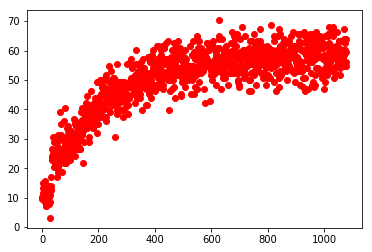

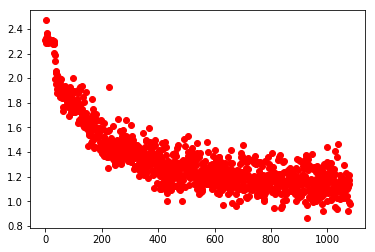

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

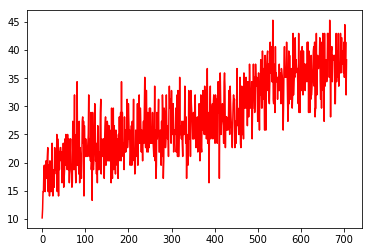

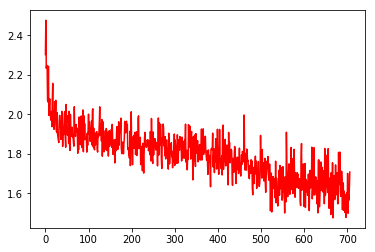

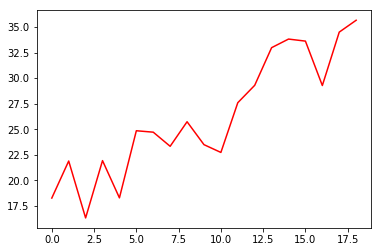

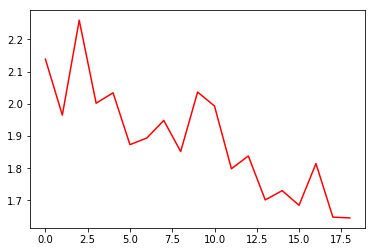

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()